In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
        "num_classes": out["num_classes"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(["num_classes", "train_size"]).agg(["mean", "std", "count", sem])

In [8]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [10]:
grouped_res.loc[2, :]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     4  0.0  0.583000  0.064114     4  0.032057   
20                1.0  0.0     5  0.0  0.676800  0.034339     5  0.015357   
50                1.0  0.0     5  0.0  0.742400  0.046355     5  0.020731   
100               1.0  0.0     5  0.0  0.871200  0.042464     5  0.018991   
200               1.0  0.0     3  0.0  0.934667  0.015144     3  0.008743   
500               1.0  0.0     5  0.0  0.933600  0.013145     5  0.005879   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.537379  0.106531     4  0.053266  0.583000  0.064114     4   
20          0.664946  0.050435     5  0.022555  0.676800  0.034339     5   
50          0.740264  0.048005     5  0.021468  0.742400  0.046355     5   
100         0.870830  0.042595     5  0.019049  0.871200  0.042464     5   
200         0.934654  0.015132     3  0.008736  0.934667  0.015144     3   
500         0.933561  0.013145     5  0.005879  0.933600  0.013145     5   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.032057  0.166000  0.128229     4  0.064114  
20          0.015357  0.353600  0.068679     5  0.030714  
50          0.020731  0.484800  0.092710     5  0.041461  
100         0.018991  0.742400  0.084928     5  0.037981  
200         0.008743  0.869333  0.030288     3  0.017487  
500         0.005879  0.867200  0.026291     5  0.011758

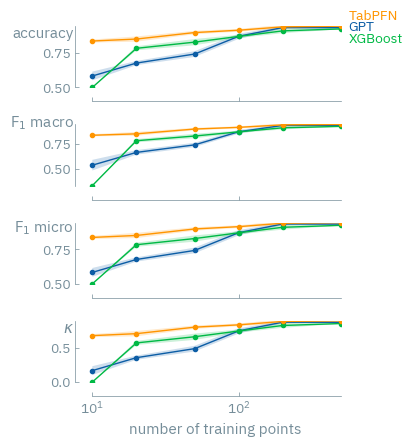

In [11]:
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

ax[0].set_xscale("log")
for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    range_frame(
        ax[i],
        grouped_res.loc[2, :].index,
        np.stack(
            [
                grouped_res.loc[2, :][metric]["mean"],
                grouped_xgboost_res.loc[2, :][metric]["mean"],
                grouped_tabpfn_res.loc[2, :][metric]["mean"],
            ]
        ).flatten(),
        0.001,
    )
    ax[i].plot(
        grouped_res.loc[2, :].index,
        grouped_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, :].index,
        grouped_res.loc[2, :][metric]["mean"] - grouped_res.loc[2, :][metric]["sem"],
        grouped_res.loc[2, :][metric]["mean"] + grouped_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        - grouped_xgboost_res.loc[2, :][metric]["sem"],
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        + grouped_xgboost_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"] - grouped_tabpfn_res.loc[2, :][metric]["sem"],
        grouped_tabpfn_res.loc[2, :][metric]["mean"] + grouped_tabpfn_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )


matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)


fig.savefig("polymner-classification_results_2.pdf", bbox_inches="tight")

In [12]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.3609255190612268

In [13]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.3788486093015747

In [14]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[2, :].index,
                grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[2, :].index,
                grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

In [15]:
from gptchem.evaluator import add_kappa_vlines

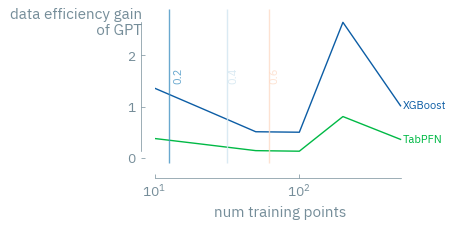

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.plot(
    grouped_res.loc[
        2,
        :,
    ].index,
    intersections,
    label="XGBoost",
)
ax.plot(
    grouped_res.loc[
        2,
        :,
    ].index,
    intersections_tabpfn,
    label="TabPFN",
)

matplotx.line_labels(fontsize=8)
add_kappa_vlines(
    grouped_res.loc[2, :].index, grouped_res.loc[2, :]["kappa"]["mean"], ymax=2.9, ymin=-0.1
)
ylabel_top("data efficiency gain\n  of GPT", x_pad=0.03)
plt.xlabel("num training points", labelpad=4)

plt.xscale("log")

range_frame(
    ax,
    grouped_res.loc[
        2,
        :,
    ].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)
plt.savefig("polymer-2-data-efficiency.pdf", bbox_inches="tight")

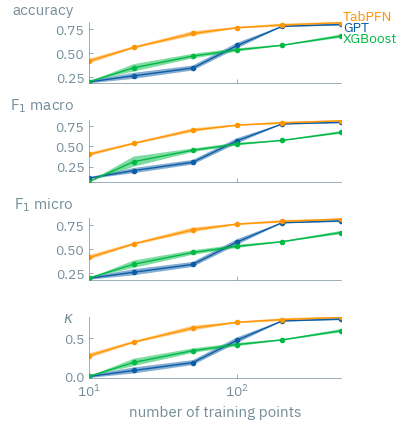

In [17]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, :].index,
        grouped_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, :].index,
        grouped_res.loc[5, :][metric]["mean"] - grouped_res.loc[5, :][metric]["sem"],
        grouped_res.loc[5, :][metric]["mean"] + grouped_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        - grouped_xgboost_res.loc[5, :][metric]["sem"],
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        + grouped_xgboost_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"] - grouped_tabpfn_res.loc[5, :][metric]["sem"],
        grouped_tabpfn_res.loc[5, :][metric]["mean"] + grouped_tabpfn_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )


matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)


ax[0].set_xscale("log")
fig.savefig("polymner-classification_results_5.pdf", bbox_inches="tight")

In [18]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[5, :].index,
                grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[5, :].index,
                grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

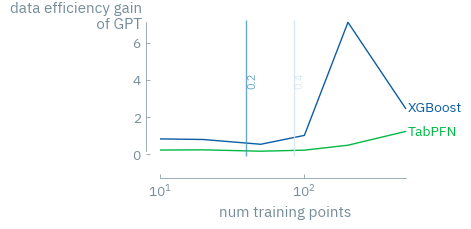

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(
    grouped_res.loc[
        5,
        :,
    ].index,
    intersections,
    label="XGBoost",
)
ax.plot(
    grouped_res.loc[
        5,
        :,
    ].index,
    intersections_tabpfn,
    label="TabPFN",
)

matplotx.line_labels()
add_kappa_vlines(
    grouped_res.loc[5, :].index, grouped_res.loc[5, :]["kappa"]["mean"], ymax=7.2, ymin=-0.1
)
ylabel_top("data efficiency gain\n  of GPT", x_pad=0.05, y_pad=-0.08)
plt.xlabel("num training points", labelpad=4)

plt.xscale("log")

range_frame(
    ax,
    grouped_res.loc[
        5,
        :,
    ].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)

plt.savefig("polymer-5-data-efficiency.pdf", bbox_inches="tight")